# **YOLOv8 PREDICTION**

## **Initial configuration**

**Install packages**

In [ ]:
# !pip install ultralytics==8.2.103
# !pip install onnx==1.17.0
# !pip install onnxslim==0.1.34
# !pip install onnxruntime==1.20.1
# !pip install onnxruntime-gpu==1.20.1
# !pip install tensorrt==10.7.0
# !pip install py-cpuinfo
# !pip install psutil
# !pip install gputil

**Import libraries**

In [29]:
import cpuinfo
import GPUtil
import matplotlib.pyplot as plt
import os
import platform
import psutil
import subprocess
import torch

from PIL import Image
from ultralytics import YOLO

In [3]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4034MiB)
Setup complete ✅ (8 CPUs, 7.6 GB RAM, 69.0/294.2 GB disk)


**Machine specifications**

In [4]:
def print_machine_specs():
  # Operating System
  print("Operating System:")
  print(f"  Name: {platform.system()} {platform.release()}")
  print(f"  Version: {platform.version()}")
  print(f"  Processor: {platform.processor()}")
  print(f"  Architecture: {platform.architecture()[0]}\n")

  # OS - Distribution
  print("OS - Distribution:")
  print(f"  pretty name: {platform.freedesktop_os_release()['PRETTY_NAME']}")
  print(f"  name: {platform.freedesktop_os_release()['NAME']}")
  print(f"  version: {platform.freedesktop_os_release()['VERSION']}")
  print(f"  version codename: {platform.freedesktop_os_release()['VERSION_CODENAME']}")
  print(f"  id: {platform.freedesktop_os_release()['ID']}")
  print(f"  id like: {platform.freedesktop_os_release()['ID_LIKE']} \n")

  # CPU Information
  cpu = cpuinfo.get_cpu_info()
  print("CPU Information:")
  print(f"  Processor: {cpu['brand_raw']}")
  print(f"  Cores: {psutil.cpu_count(logical=False)}")
  print(f"  Threads: {psutil.cpu_count(logical=True)}")
  print(f"  Max Frequency: {psutil.cpu_freq().max:.2f} MHz\n")

  # Memory Information
  virtual_memory = psutil.virtual_memory()
  print("Memory Information:")
  print(f"  Total: {virtual_memory.total / (1024 ** 3):.2f} GB")
  print(f"  Available: {virtual_memory.available / (1024 ** 3):.2f} GB\n")

  # Disk Information
  disk_usage = psutil.disk_usage('/')
  print("Disk Information:")
  print(f"  Total: {disk_usage.total / (1024 ** 3):.2f} GB")
  print(f"  Used: {disk_usage.used / (1024 ** 3):.2f} GB")
  print(f"  Free: {disk_usage.free / (1024 ** 3):.2f} GB\n")

  # GPU Information (if available)
  try:
    gpus = GPUtil.getGPUs()
    print("GPU Information:")
    for gpu in gpus:
      print(f"  GPU: {gpu.name}")
      print(f"  Memory Total: {gpu.memoryTotal} MB")
      print(f"  Memory Free: {gpu.memoryFree} MB")
      print(f"  Memory Used: {gpu.memoryUsed} MB\n")
  except ImportError:
    print("GPU Information: GPUtil not installed. Install it using `pip install gputil`.\n")

  # Python Information
  print("Python Environment:")
  print(f"  Version: {platform.python_version()}")
  print(f"  Compiler: {platform.python_compiler()}\n")

print_machine_specs()

Operating System:
  Name: Linux 6.8.0-51-generic
  Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
  Processor: x86_64
  Architecture: 64bit

OS - Distribution:
  pretty name: Ubuntu 22.04.5 LTS
  name: Ubuntu
  version: 22.04.5 LTS (Jammy Jellyfish)
  version codename: jammy
  id: ubuntu
  id like: debian 

CPU Information:
  Processor: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz
  Cores: 4
  Threads: 8
  Max Frequency: 4000.00 MHz

Memory Information:
  Total: 7.61 GB
  Available: 3.15 GB

Disk Information:
  Total: 294.23 GB
  Used: 54.02 GB
  Free: 225.19 GB

GPU Information:
  GPU: NVIDIA GeForce GTX 1050 Ti
  Memory Total: 4096.0 MB
  Memory Free: 4031.0 MB
  Memory Used: 4.0 MB

Python Environment:
  Version: 3.12.7
  Compiler: GCC 11.2.0



**Graphic cards features**

In [13]:
# Verify cuda available device
cuda_device_num = torch.cuda.device_count()
if not cuda_device_num:
  print("\033[93m WARNING: Cuda devices are not available! \033[0m")
else:
  print(f"\033[34m INFO: There {'is' if cuda_device_num == 1 else 'are'} {cuda_device_num} pytorch cuda devices! \033[0m")
  print(f"\033[34m       Pyorch cuda version: {torch.version.cuda} \033[0m")
  print(f"\033[34m-\033[0m" * 35)
  for index in  range(cuda_device_num):
    print(f"\033[34m GPU {index}: {torch.cuda.get_device_name(index)} \033[0m")
    print(f"\033[34m \tTotal cuda device memory {torch.cuda.mem_get_info(0)[1] // 2 ** 20} MiB\033[0m")
    print(f"\033[34m \tFree cuda device memory {torch.cuda.mem_get_info(index)[0] // 2 ** 20} MiB\033[0m\n")

  print("Graphic cards information")
  print(subprocess.check_output("nvidia-smi").decode())

 INFO: There is 1 pytorch cuda devices! 
       Pyorch cuda version: 12.4 
-----------------------------------
 GPU 0: NVIDIA GeForce GTX 1050 Ti 
 	Total cuda device memory 4034 MiB
 	Free cuda device memory 3986 MiB

Graphic cards information
Mon Jan 27 20:51:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0 Off |           

**Directory structure**

In [20]:
# Run local or not
PROJ_ROOT = os.getcwd()
local = True if os.path.basename(PROJ_ROOT) == 'notebooks' else False

# Directories path
if not local:
  os.makedirs('models/trained', exist_ok=True)
  models_relative_path = 'models'
else:
  models_relative_path = '../models'

MODELS_DIR = os.path.join(PROJ_ROOT, models_relative_path)
TRAINED_MODEL_DIR = os.path.join(MODELS_DIR, "trained")

# Print directories paths
print(f"\033[34m INFO: Trained model in {TRAINED_MODEL_DIR}. \033[0m")

# Print warning
print(f"\033[93m WARNING: You need to load the trained model into {TRAINED_MODEL_DIR}. \033[0m")

 INFO: Trained model in /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained. 


**Configuration variables**

In [22]:
# Configuration class
class CFG:
  # Predict variables
  PREDICT_DEVICE = "0" if cuda_device_num else "cpu"
  PREDICT_MODEL_NAME = "ppe_detection.onnx"
  PREDICT_MODEL_PATH = os.path.join(TRAINED_MODEL_DIR, PREDICT_MODEL_NAME)
  PREDICT_PROJECT_NAME = ""
  PREDICT_PROJECT_PATH = os.path.join(MODELS_DIR, PREDICT_PROJECT_NAME)
  PREDICT_NAME = ""

# Print information
print("\nPrediction information")
print(f"Predict model name: {CFG.PREDICT_MODEL_NAME}")
print(f"Predict model path: {CFG.PREDICT_MODEL_PATH}")
print(f"Predict project path: {CFG.PREDICT_PROJECT_PATH}")
print(f"Predict name: {CFG.PREDICT_NAME}")


Prediction information
Predict model name: ppe_detection.onnx
Predict model path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained/ppe_detection.onnx
Predict project path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/
Predict name: 


## **Prediction**

**Verify the model**

In [23]:
if not os.path.isfile(CFG.PREDICT_MODEL_PATH):
  print(f"\033[31m ERROR: Is posible the prediction model {CFG.PREDICT_MODEL_PATH} don't exist. \033[0m")
else:
  print(f"\033[34m INFO: The prediction model {CFG.PREDICT_MODEL_PATH} exists. \033[0m")

 INFO: The prediction model /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained/ppe_detection.onnx exists. 


**Load the model**

In [24]:
try:
  predict_model = YOLO(CFG.PREDICT_MODEL_PATH, task="detect")
  print(f"The {CFG.PREDICT_MODEL_PATH} was loaded.")
except:
  print(f"Error loading the {CFG.PREDICT_MODEL_PATH} model.")

The /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained/ppe_detection.onnx was loaded.


**Predict settings**

In [25]:
# Project configuration
predict_project_name = ""
predict_name = ""

# Project name
if CFG.PREDICT_PROJECT_NAME:
  predict_project_name = CFG.PREDICT_PROJECT_NAME
elif not predict_model.ckpt:
  predict_project_name = "predict_yolov8_ppe_detection"
else:
  predict_project_name = f"predict_{predict_model.ckpt["train_args"]["project"].split("/")[-1]}"

# Predict name
if CFG.PREDICT_NAME:
  predict_name = CFG.PREDICT_NAME
elif not predict_model.ckpt:
  predict_name = predict_model.model_name.split("/")[-1].replace(".", "_")
else:
  predict_name = predict_model.ckpt["train_args"]["name"]

predict_project_path = os.path.join(MODELS_DIR, predict_project_name)

print("Predict model path:\t", CFG.PREDICT_MODEL_PATH)
print("Predict project name:\t", predict_project_name)
print("Predict project path:\t", predict_project_path)
print("Predict name:\t", predict_name)

Predict model path:	 /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained/ppe_detection.onnx
Predict project name:	 predict_yolov8_ppe_detection
Predict project path:	 /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/predict_yolov8_ppe_detection
Predict name:	 ppe_detection_onnx


In [26]:
cfg_predict = {
  # Inference arguments
  "source": "https://www.cdc.gov/niosh/media/images/CONaerialviewthumb.jpg",
  "stream": False,
  "conf": 0.001,
  "iou": 0.7,
  "imgsz": 640,
  "half": False,
  "device": CFG.PREDICT_DEVICE,
  "vid_stride": 1,
  "stream_buffer": False,
  "visualize": False,
  "augment": False,
  "agnostic_nms": False,
  "classes": [0],
  "project": predict_project_path,
  "name": predict_name,

  # Visualization arguments
  "show": False,
  "save": True,
  "save_frames": False,
  "save_txt": False,
  "save_conf": False,
  "save_crop": False,
  "show_labels": True,
  "show_conf": True,
  "show_boxes": True,
  "line_width": None
}

for key, value in cfg_predict.items():
  print(key, ":", value)

source : https://www.cdc.gov/niosh/media/images/CONaerialviewthumb.jpg
stream : False
conf : 0.001
iou : 0.7
imgsz : 640
half : False
device : 0
vid_stride : 1
stream_buffer : False
visualize : False
augment : False
agnostic_nms : False
classes : [0]
project : /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/predict_yolov8_ppe_detection
name : ppe_detection_onnx
show : False
save : True
save_frames : False
save_txt : False
save_conf : False
save_crop : False
show_labels : True
show_conf : True
show_boxes : True
line_width : None


**Predict model**

In [27]:
predict_results = predict_model(**cfg_predict)

Loading /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/trained/ppe_detection.onnx for ONNX Runtime inference...



/home/harvey/anaconda3/envs/yolo_detection/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
100%|██████████| 306k/306k [00:00<00:00, 461kB/s]


image 1/1 /home/harvey/Documents/yolo_ppe_detection/notebooks/CONaerialviewthumb.jpg: 640x640 55 hard_hats, 98.6ms
Speed: 148.1ms preprocess, 98.6ms inference, 1405.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/predict_yolov8_ppe_detection/ppe_detection_onnx


**Prediction results**

Original Image path : /home/harvey/Documents/yolo_ppe_detection/notebooks/CONaerialviewthumb.jpg
Result Image path : /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/predict_yolov8_ppe_detection/ppe_detection_onnx/CONaerialviewthumb.jpg
hard_hat : 55


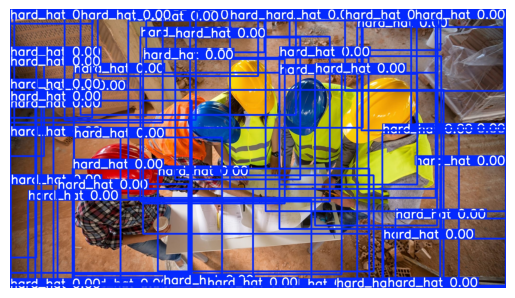

In [30]:
for result in predict_results:
    print("Original Image path", ":", result.path)
    print("Result Image path", ":", os.path.join(result.save_dir, result.path.split("/")[-1]))
    for key, value in result.names.items():
        print(value, ":", result.boxes.cls.cpu().tolist().count(key)) if key in result.boxes.cls else None
    orig_img = Image.open(result.path)
    pred_img = Image.open(os.path.join(result.save_dir, result.path.split("/")[-1]))
    plt.imshow(pred_img)
    plt.axis("off")
plt.show()